In [1]:
import pandas as pd
from itertools import combinations
import openai
import base64
import numpy as np
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
IMAGE_FOLDER = "data\\120 Rocks"

In [3]:
human_data = pd.read_csv("data\\rocks_120_full_matrix.csv", index_col=0)

In [4]:
import os

# Get sorted list of file names (without extension) from the directory
rock_filenames = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")])

# Set the DataFrame's index and columns to these filenames
human_data.index = rock_filenames
human_data.columns = rock_filenames

In [5]:
human_data

,I_Andesite_1_120,I_Andesite_2_120,I_Andesite_3_120,I_Andesite_4_120,I_Basalt_1_120,I_Basalt_2_120,I_Basalt_3_120,I_Basalt_4_120,I_Diorite_1_120,I_Diorite_2_120,...,S_Rock Salt_3_120,S_Rock Salt_4_120,S_Sandstone_1_120,S_Sandstone_2_120,S_Sandstone_3_120,S_Sandstone_4_120,S_Shale_1_120,S_Shale_2_120,S_Shale_3_120,S_Shale_4_120
I_Andesite_1_120,NaN,6.571429,5.166666,6.583334,4.200000,2.000000,4.800000,4.714286,2.666667,1.500000,...,3.000000,1.571428,2.333333,2.666667,5.333334,3.666667,5.000000,4.000000,5.714286,7.000000
I_Andesite_2_120,6.571429,NaN,6.312500,8.333333,2.857143,3.200000,4.714286,2.000000,6.428571,6.200000,...,2.500000,5.000000,2.800000,2.142857,2.285714,3.000000,4.000000,3.333333,5.285714,3.000000
I_Andesite_3_120,5.166666,6.312500,NaN,8.444445,4.333334,3.800000,3.500000,3.428571,5.428571,7.625000,...,3.000000,5.000000,2.000000,1.750000,4.000000,2.500000,2.142857,1.500000,3.800000,3.571429
I_Andesite_4_120,6.583334,8.333333,8.444445,NaN,4.200000,4.000000,3.000000,5.333334,7.000000,7.000000,...,4.000000,3.500000,6.500000,1.500000,3.222222,2.750000,3.000000,3.333333,7.000000,3.000000
I_Basalt_1_120,4.200000,2.857143,4.333334,4.200000,NaN,7.400000,8.153846,7.533333,4.571429,1.666667,...,1.250000,3.571429,5.166666,3.750000,5.800000,4.666666,6.875000,5.000000,5.571429,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S_Sandstone_4_120,3.666667,3.000000,2.500000,2.750000,4.666666,6.750000,4.875000,6.750000,2.750000,2.333333,...,2.000000,2.333333,5.750000,7.000000,7.333334,NaN,5.666666,2.500000,4.000000,4.000000
S_Shale_1_120,5.000000,4.000000,2.142857,3.000000,6.875000,5.111111,7.250000,5.666666,4.000000,3.333333,...,2.000000,5.400000,7.000000,6.400000,5.600000,5.666666,NaN,6.200000,7.833334,6.875000
S_Shale_2_120,4.000000,3.333333,1.500000,3.333333,5.000000,6.000000,3.500000,3.000000,1.500000,2.000000,...,1.666667,3.333333,NaN,NaN,3.000000,2.500000,6.200000,NaN,7.444445,6.550000
S_Shale_3_120,5.714286,5.285714,3.800000,7.000000,5.571429,4.500000,4.750000,5.000000,3.166667,3.166667,...,2.000000,NaN,2.777778,6.666666,3.750000,4.000000,7.833334,7.444445,NaN,7.875000


In [ ]:
client = openai.OpenAI()

In [7]:
def encode_image(image, folder=IMAGE_FOLDER):
    image_path = os.path.join(folder, f"{image}.jpg")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [8]:
SYSTEM_PROMPT = (
    "You are assisting in a study in which you are shown pairs of rocks and "
    "rate how visually similar they are on a scale from 1 to 9, with 1 being most dissimilar, "
    "5 being moderately similar, and 9 being most similar. "
    "You are shown examples of highly similar, moderately similar, and highly dissimilar pairs. "
    "You use these examples to anchor your judgments. "
    # ChatGPT is biased to give low similarities. Adding this instruction helps.
    "You use the full range of the scale and only respond with a 1 or 2 when the pair is extremely dissimilar. "
    "You only respond with a single number from 1 to 9, without explaining your reasoning."
    )

SIMILAR_EXAMPLE_PROMPT = (
    "This is an example of a highly similar pair of rocks."
)

DISSIMILAR_EXAMPLE_PROMPT = (
    "This is an example of a highly dissimilar pair of rocks."
)

MEDIUM_EXAMPLE_PROMPT = (
    "This is an example of a moderately similar pair of rocks."
)

QUESTION_PROMPT = (
    "From 1-9, how visually similar are these two rocks?"
)

SIMILAR_ROCK1 = "I_Obsidian_09"
SIMILAR_ROCK2 = "M_Anthracite_12"

DISSIMILAR_ROCK1 = "S_Rock Salt_12"
DISSIMILAR_ROCK2 = "S_Sandstone_12"

MEDIUM_ROCK1 = "I_Andesite_06"
MEDIUM_ROCK2 = "I_Peridotite_11"

SEED = 123

In [9]:
def create_messages(prompt, rocks,folder=IMAGE_FOLDER):
    messages = {"role": "user",
       "content": [{"type": "text", "text": prompt}] + [
         {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encode_image(rock, folder)}"
            },
          }
        for rock in rocks]
    }
    return messages

In [10]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

In [11]:
def get_responses(rock1, rock2): 
  response = completion_with_backoff(
    model="gpt-4.1",
    messages=[
      {"role": "system", "content": SYSTEM_PROMPT},
      create_messages(SIMILAR_EXAMPLE_PROMPT, (SIMILAR_ROCK1, SIMILAR_ROCK2), "data\\360 rocks"),
      create_messages(MEDIUM_EXAMPLE_PROMPT, (MEDIUM_ROCK1, MEDIUM_ROCK2), "data\\360 rocks"),
      create_messages(DISSIMILAR_EXAMPLE_PROMPT, (DISSIMILAR_ROCK1, DISSIMILAR_ROCK2), "data\\360 rocks"),
      create_messages(QUESTION_PROMPT, (rock1, rock2)),
    ],
    logprobs=True,
    top_logprobs=20,
    seed=SEED,
    max_tokens=1,
  )
  return response

In [12]:
import json
with open("number_map.json", "r", encoding="utf-8") as f:
    number_map = json.load(f)

In [13]:
def get_average_rating(logprobs):
    # We get a weighted average using the logprobs. The logprobs are actually nondeterministic
    # even with a fixed random seed, so different runs might have slightly different results.
    ratings = np.array([i+1 for i in range(9)])
    weights = np.array([0.]*9)
    for lp in logprobs:
        token = token = lp.token.strip().lower()
        i = number_map.get(token, token) # Convert what we can to numerical digits
        try:
            i = int(i) - 1
            weights[i] += np.exp(lp.logprob)
        except:
            continue
    try:
        av = np.average(ratings, weights=weights)
    except:
        av = 0.0
    return av


In [14]:
import csv
import random

pairs = [comb for comb in combinations(human_data.columns, 2)]
random.shuffle(pairs)
for pair in pairs[:500]:
    rock1, rock2 = pair
    human = human_data[rock1][rock2]
    response = get_responses(rock1, rock2)
    logprobs = response.choices[0].logprobs.content[0].top_logprobs
    chatgpt = get_average_rating(logprobs)
    with open("chatgpt_similarities_120.csv", mode="a", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["Rock1", "Rock2", "Human Rating", "ChatGPT Rating", "Response"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerow({
            "Rock1": rock1,
            "Rock2": rock2,
            "Human Rating": human,
            "ChatGPT Rating": chatgpt,
            "Response": response
        })

In [15]:
results = pd.read_csv("chatgpt_similarities_120.csv")


In [16]:
results

,Rock1,Rock2,Human Rating,ChatGPT Rating,Response
0,I_Basalt_3_120,I_Pumice_1_120,5.142857,3.004012,ChatCompletion(id='chatcmpl-Ba6uIkLqO2pCiy2n1O...
1,I_Gabbro_2_120,S_Conglomerate_1_120,2.888889,2.999572,ChatCompletion(id='chatcmpl-Ba6uP6uFYO4ZGnrCN8...
2,M_Anthracite_4_120,S_Conglomerate_3_120,2.500000,1.022977,ChatCompletion(id='chatcmpl-Ba6uVjiRgJw85uD0UY...
3,I_Pegmatite_4_120,M_Amphibolite_1_120,1.250000,2.000261,ChatCompletion(id='chatcmpl-Ba6ucDee2pNEK9eVpq...
4,I_Peridotite_3_120,S_Rock Salt_3_120,3.800000,1.999904,ChatCompletion(id='chatcmpl-Ba6uhM9qMtobLhGiq6...
...,...,...,...,...,...
495,M_Phyllite_2_120,S_Dolomite_4_120,4.875000,2.000013,ChatCompletion(id='chatcmpl-Ba7yfbhHnF7uOgNJkz...
496,M_Migmatite_1_120,S_Rock Gypsum_4_120,3.857143,1.148047,ChatCompletion(id='chatcmpl-Ba7yjPxLvt89B58bW3...
497,I_Basalt_3_120,M_Quartzite_3_120,1.750000,2.679179,ChatCompletion(id='chatcmpl-Ba7yqZTKQt844zfLhP...
498,I_Granite_2_120,I_Obsidian_2_120,1.000000,1.148047,ChatCompletion(id='chatcmpl-Ba7yvfv4sncu6MLvpM...


In [22]:
corr = results.corr(numeric_only=True).loc["Human Rating", "ChatGPT Rating"]

Text(0.1, 0.9, 'r = 0.59')

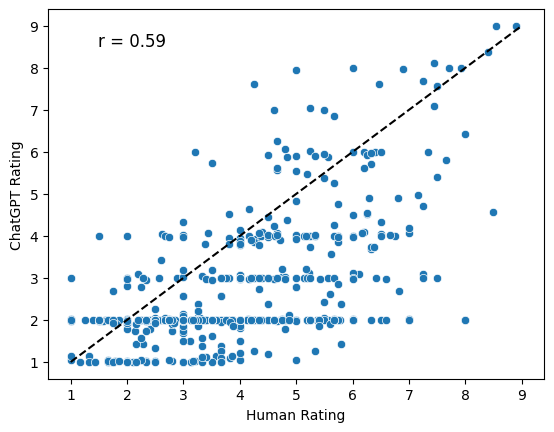

In [28]:
sns.scatterplot(results, x="Human Rating", y="ChatGPT Rating")
plt.plot([1, 9], [1, 9], 'k--')
plt.annotate(f"r = { round(corr, 2)}", xy=(0.1, 0.9), xycoords="axes fraction", fontsize=12)

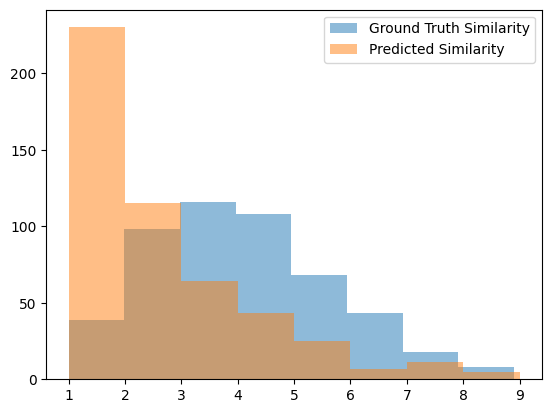

In [41]:
plt.hist(results['Human Rating'], alpha=0.5, label='Ground Truth Similarity', bins=8)
plt.hist(results['ChatGPT Rating'], alpha=0.5, label='Predicted Similarity', bins=8)
plt.legend()

<Axes: >

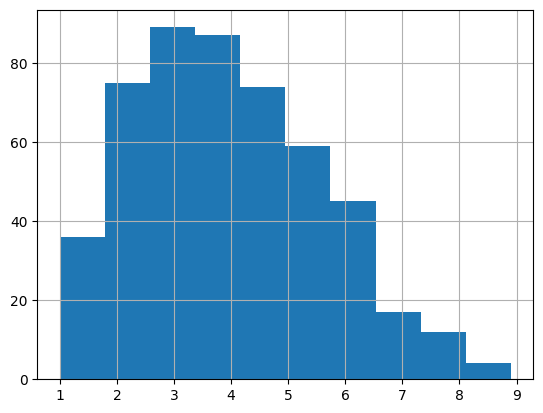

In [19]:
results["Human Rating"].hist()

<Axes: >

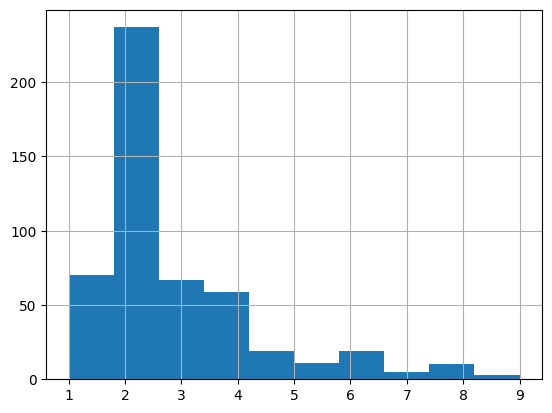

In [20]:
results["ChatGPT Rating"].hist()